## **Revisión de Imagenes 360**
---


In [48]:
import cv2
import numpy as np
import py360convert
import csv
import os
import time
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import random
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing

# Rutas de las imágenes 360 (OBLIGATORIO)
carpeta = r"C:\Users\Juan Camilo\Downloads\Imagenes 360\Carepa\2. Fotografias 360\prueba"
csv_path = os.path.join(carpeta, 'reporte.csv')

# Campos para el CSV
campos = [
    'archivo',
    'exposicion',
    'exposicion_caras',
    'borrosa',
    'borrosidad_caras',
    #'lap_var_prom',
    #'tenengrad_prom',
    #'brenner_prom',
    #'dog_prom',
    #'entropy_prom',
    'combined_score_prom'
]

# Pesos para combinación de métricas
pesos = {
    'lap_var': 0.2,
    'tenengrad': 0.25,
    'brenner': 0.25,
    'dog': 0.2,
    'entropy': 0.1
}

# Máximos esperados (o valores calibrados tras exploración previa)
mts_max = {
    'lap_var': 200.0,
    'tenengrad': 1e3,
    'brenner': 1e4,
    'dog': 4.0,
    'entropy': 1.0
}
# Rutas para el modelo de ML (OPCIONAL)
data_dir = r"C:\Users\Juan Camilo\Downloads\Imagenes 360\dataset"
model_path = r"C:\Users\Juan Camilo\Downloads\Imagenes 360\dataset\modelo_fachadas.pth"
history_csv = r"C:\Users\Juan Camilo\Downloads\Imagenes 360\dataset\historial_analisis.csv"

#### **Revision básica**
---

##### **Funciones**

In [54]:
def detectar_borrosidad_adaptativa(region):
    """
    Detecta borrosidad mediante análisis adaptativo de la imagen.
    - Analiza el histograma para determinar rango dinámico
    - Calcula contenido de bordes potenciales
    - Establece umbral adaptativo para varianza de Laplaciano
    """
    # Convertir a escala de grises
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
    
    # Calcular histograma y rango dinámico
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_norm = hist.ravel() / hist.sum()
    cumsum = np.cumsum(hist_norm)
    
    # Calcular percentiles para determinar rango dinámico
    p_low = np.argmax(cumsum >= 0.05)
    p_high = np.argmax(cumsum >= 0.95)
    dynamic_range = p_high - p_low
    
    # Calcular contenido de bordes potenciales
    edges = cv2.Canny(gray, 50, 150)
    edge_content = np.sum(edges > 0) / edges.size
    
    # Calcular varianza de Laplaciano
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    varianza = laplacian.var()
    
    # Establecer umbral adaptativo basado en características de la imagen
    if dynamic_range < 70:  # Imagen de bajo contraste
        umbral = 60  # Umbral bajo para evitar falsos negativos
    elif edge_content < 0.1:  # Pocos bordes potenciales
        umbral = 50  # Umbral bajo
    elif edge_content > 0.2:  # Muchos bordes potenciales
        umbral = 150  # Umbral alto
    else:
        # Umbral base ajustado por rango dinámico
        umbral = max(50, min(100, dynamic_range * 0.5))
    
    # Determinar si es borrosa
    borrosa = varianza < umbral
    
    # Devolver resultados y métricas para análisis
    return borrosa, {
        'varianza': varianza,
        'umbral': umbral,
        'rango_dinamico': dynamic_range,
        'contenido_bordes': edge_content
    }

def chequear_exposicion(imagen, bajo=18, alto=237, pct_umbral=0.6):
    """
    Clasifica la exposición de una imagen:
    - 'subexpuesta' si más del pct_umbral de los pixeles son muy oscuros.
    - 'sobreexpuesta' si más del pct_umbral de los pixeles son muy claros.
    - 'correcta' en caso contrario.
    """
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    pct_bajo = np.mean(gray < bajo)
    pct_alto = np.mean(gray > alto)
    if pct_bajo > pct_umbral:
        return "subexpuesta"
    elif pct_alto > pct_umbral:
        return "sobreexpuesta"
    else:
        return "correcta"

def procesar_imagen_para_visualizacion(nombre_imagen):
    """
    Versión especial para visualización que incluye heatmaps
    """
    imagen_path = os.path.join(carpeta, nombre_imagen)
    imagen = cv2.imread(imagen_path)
    if imagen is None:
        return None
    
    cubemap = py360convert.e2c(imagen, face_w=2048, mode='nearest', cube_format='list')
    borrosidad_caras = []
    metricas_caras = []
    heatmaps = []
    exposicion_caras = []
    
    for i in range(4):
        cara = cubemap[i]
        h, w, _ = cara.shape
        buffer_h, buffer_w = int(h * 0.01), int(w * 0.01)
        zona = cara[buffer_h:h-buffer_h, buffer_w:w-buffer_w]
        
        exposicion_cara = chequear_exposicion(zona)
        exposicion_caras.append(exposicion_cara)
        
        # Convertir a escala de grises para heatmap
        gray = cv2.cvtColor(zona, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        heatmap = cv2.convertScaleAbs(laplacian)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        
        borrosa, metricas = detectar_borrosidad_adaptativa(zona)
        borrosidad_caras.append(borrosa)
        metricas_caras.append(metricas)
        heatmaps.append(heatmap)
    
    borrosa = sum(borrosidad_caras) >= 1
    
    return {
        'archivo': nombre_imagen,
        'exposicion': any(e != 'correcta' for e in exposicion_caras),
        'exposicion_caras': exposicion_caras,
        'borrosa': borrosa,
        'borrosidad_caras': borrosidad_caras,
        'metricas_borrosidad': metricas_caras,
        'heatmaps': heatmaps
    }

def mostrar_varias_imagenes(nombres_archivos, n=5):
    if not nombres_archivos:
        print("No hay imágenes para mostrar.")
        return
    
    resultados = []
    for nombre in nombres_archivos[:n]:
        resultado = procesar_imagen_para_visualizacion(nombre)
        if resultado:
            resultados.append(resultado)
    
    for idx, fila in enumerate(resultados):
        img_path = os.path.join(carpeta, fila['archivo'])
        img = cv2.imread(img_path)
        if img is not None:
            cubemap = py360convert.e2c(img, face_w=2048, mode='nearest', cube_format='list')
            titulos = ['Frontal', 'Derecha', 'Trasera', 'Izquierda']
            plt.figure(figsize=(16, 4))
            for i in range(4):
                plt.subplot(1, 4, i+1)
                plt.imshow(cv2.cvtColor(cubemap[i], cv2.COLOR_BGR2RGB))
                plt.title(
                    f"{titulos[i]}\n"
                    f"Borrosa: {fila['borrosidad_caras'][i]}\n"
                    f"Exposición: {fila['exposicion_caras'][i]}\n"
                    f"Varianza: {fila['metricas_borrosidad'][i]['varianza']:.1f} | Umbral: {fila['metricas_borrosidad'][i]['umbral']}"
                )
                plt.axis('off')
            plt.suptitle(
                f"Imagen #{idx+1}: {fila['archivo']} (Borrosa: {fila['borrosa']})"
            )
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        else:
            print(f"No se pudo cargar la imagen {fila['archivo']}.")

def mostrar_heatmaps(nombres_archivos, n=5):
    if not nombres_archivos:
        print("No hay imágenes para mostrar mapa de calor.")
        return
    
    resultados = []
    for nombre in nombres_archivos[:n]:
        resultado = procesar_imagen_para_visualizacion(nombre)
        if resultado:
            resultados.append(resultado)
    
    titulos = ['Frontal','Derecha','Trasera','Izquierda']
    for idx, fila in enumerate(resultados):
        plt.figure(figsize=(16, 4))
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.imshow(fila['heatmaps'][i])
            plt.title(f"{titulos[i]}\nBorrosa: {fila['borrosidad_caras'][i]}")
            plt.axis('off')
        plt.suptitle(
            f"Imagen #{idx+1}: {fila['archivo']} (Borrosa: {fila['borrosa']})"
        )
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
def calcular_metricas_blur(gray):
    """
    Calcula varias métricas de enfoque sin referencia.
    """
    # 1) Varianza del Laplaciano
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    m_lap = lap.var()

    # 2) Tenengrad (Sobel)
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    m_ten = np.mean(gx**2 + gy**2)

    # 3) Brenner
    diff = gray[2:,:].astype(float) - gray[:-2,:].astype(float)
    m_bre = np.mean(diff**2)

    # 4) DoG (Difference of Gaussians)
    g1 = cv2.GaussianBlur(gray, (5,5), 1)
    g2 = cv2.GaussianBlur(gray, (5,5), 2)
    m_dog = np.mean(cv2.absdiff(g1, g2))

    # 5) Entropía
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).ravel()
    p = hist / hist.sum()
    m_ent = -np.sum(p[p>0] * np.log2(p[p>0]))

    return {
        'lap_var': m_lap,
        'tenengrad': m_ten,
        'brenner': m_bre,
        'dog': m_dog,
        'entropy': m_ent
    }

def combinar_metricas(mets):
    """
    Normaliza y combina métricas en un score único [0,1].
    """
    norm = {}
    for k, v in mets.items():
        norm[k] = np.clip(v / (mts_max[k] + 1e-8), 0.0, 1.0)
    combined = sum(norm[k] * pesos[k] for k in mets)
    return combined

def procesar_imagen(nombre_imagen, carpeta, csv_lock):
    ruta = os.path.join(carpeta, nombre_imagen)
    img = cv2.imread(ruta)
    if img is None:
        return None

    # Convertir a cubemap (4 caras) para análisis
    cubemap = py360convert.e2c(img, face_w=2048, mode='nearest', cube_format='list')

    exposiciones = []
    borrosidad_caras = []
    metricas_faces = []

    for cara in cubemap[:4]:
        h, w = cara.shape[:2]
        b_h, b_w = int(0.01*h), int(0.01*w)
        region = cara[b_h:h-b_h, b_w:w-b_w]

        exposiciones.append(chequear_exposicion(region))
        gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
        mets = calcular_metricas_blur(gray)
        mets['combined'] = combinar_metricas(mets)

        borrosa = mets['combined'] < 0.4
        borrosidad_caras.append(borrosa)
        metricas_faces.append(mets)

    # Decisión global
    borrosa_total = sum(borrosidad_caras) >= 2
    exposicion_total = any(e != 'correcta' for e in exposiciones)

    # Agregar al CSV
    resumen = {
        'archivo': nombre_imagen,
        'exposicion': exposicion_total,
        'exposicion_caras': ','.join(exposiciones),
        'borrosa': borrosa_total,
        'borrosidad_caras': ','.join(str(b) for b in borrosidad_caras),
        #'lap_var_prom': np.mean([m['lap_var'] for m in metricas_faces]),
        #'tenengrad_prom': np.mean([m['tenengrad'] for m in metricas_faces]),
        #'brenner_prom': np.mean([m['brenner'] for m in metricas_faces]),
        #'dog_prom': np.mean([m['dog'] for m in metricas_faces]),
        #'entropy_prom': np.mean([m['entropy'] for m in metricas_faces]),
        'combined_score_prom': np.mean([m['combined'] for m in metricas_faces])
    }

    # Escritura segura
    with csv_lock:
        with open(csv_path, 'a', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=campos)
            writer.writerow(resumen)

    # Liberar memoria
    del img, cubemap, metricas_faces
    gc.collect()
    return resumen

def mostrar_varias_imagenes_desde_df(df, n=5):
    if df.empty:
        print("No hay imágenes para mostrar.")
        return
    muestra = df.sample(min(n, len(df)))
    for idx, fila in muestra.iterrows():
        img_path = os.path.join(carpeta, fila['archivo'])
        img = cv2.imread(img_path)
        if img is not None:
            cubemap = py360convert.e2c(img, face_w=2048, mode='nearest', cube_format='list')
            titulos = ['Frontal', 'Derecha', 'Trasera', 'Izquierda']
            borrosidad_caras = fila['borrosidad_caras'].split(',')
            exposicion_caras = fila['exposicion_caras'].split(',')
            plt.figure(figsize=(16, 4))
            for i in range(4):
                plt.subplot(1, 4, i+1)
                plt.imshow(cv2.cvtColor(cubemap[i], cv2.COLOR_BGR2RGB))
                plt.title(
                    f"{titulos[i]}\n"
                    f"Borrosa: {borrosidad_caras[i]}\n"
                    f"Exposición: {exposicion_caras[i]}"
                )
                plt.axis('off')
            plt.suptitle(
                f"Imagen: {fila['archivo']} (Borrosa: {fila['borrosa']})"
            )
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        else:
            print(f"No se pudo cargar la imagen {fila['archivo']}.")


##### **Script básico**

In [55]:
if __name__ == '__main__':
    # Inicializar o sobreescribir CSV
    if os.path.exists(csv_path):
        os.remove(csv_path)
        print(f"Archivo existente {csv_path} eliminado. Se creará uno nuevo.")
    with open(csv_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=campos)
        writer.writeheader()

    imagenes = [f for f in os.listdir(carpeta)
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]
    total = len(imagenes)
    print(f"Total imágenes: {total}")

    manager = multiprocessing.Manager()
    lock = manager.Lock()

    start = time.time()
    procesadas = 0
    with ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as ex:
        futuros = {ex.submit(procesar_imagen, img, carpeta, lock): img for img in imagenes}
        for future in as_completed(futuros):
            procesadas += 1
            if procesadas % 10 == 0:
                elapsed = time.time() - start
                print(f"{procesadas}/{total} procesadas | {elapsed/60:.2f} min")

    total_time = (time.time() - start)/60
    print(f"Procesamiento finalizado en {total_time:.2f} minutos.")

Archivo existente C:\Users\Juan Camilo\Downloads\Imagenes 360\Carepa\2. Fotografias 360\prueba\reporte.csv eliminado. Se creará uno nuevo.
Total imágenes: 55
10/55 procesadas | 0.48 min
20/55 procesadas | 0.81 min
30/55 procesadas | 1.17 min
40/55 procesadas | 1.46 min
50/55 procesadas | 1.75 min
Procesamiento finalizado en 1.85 minutos.


In [3]:
if __name__ == "__main__":
    # 5. Leer resultados del CSV para análisis posterior
    try:
        df_resultados = pd.read_csv(csv_path)
        resultados_filtrados = df_resultados[
            (df_resultados['exposicion'] == True) | 
            (df_resultados['borrosa'] == True)
        ]
    except Exception as e:
        print(f"Error leyendo resultados: {str(e)}")
        resultados_filtrados = pd.DataFrame()

    # 6. Exportar a Shapefile (si existe el shapefile de entrada)
    shp_entrada = os.path.join(carpeta, "Centros_Fotos.shp")
    shp_salida = os.path.join(carpeta, "imagenes_filtradas.shp")

    if os.path.exists(shp_entrada) and not resultados_filtrados.empty:
        try:
            gdf = gpd.read_file(shp_entrada)
            gdf_filtrado = gdf.merge(resultados_filtrados, left_on='Nombre', right_on='archivo')
            gdf_filtrado.to_file(shp_salida, driver='ESRI Shapefile')
            print(f"SHP filtrado guardado en {shp_salida}")
        except Exception as e:
            print(f"Error exportando SHP: {str(e)}")
    else:
        if not os.path.exists(shp_entrada):
            print(f"No se encontró el shapefile de entrada: {shp_entrada}")
        if resultados_filtrados.empty:
            print("No hay imágenes que cumplan los criterios para exportar SHP.")


SHP filtrado guardado en C:\Users\Juan Camilo\Downloads\Imagenes 360\Carepa\2. Fotografias 360\imagenes_filtradas.shp


C:\Users\Juan Camilo\AppData\Local\Temp\ipykernel_8712\1957290483.py:21: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_filtrado.to_file(shp_salida, driver='ESRI Shapefile')
c:\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'exposicion_caras' to 'exposici_1'
  ogr_write(
c:\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'borrosidad_caras' to 'borrosidad'
  ogr_write(
c:\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'varianza_promedio' to 'varianza_p'
  ogr_write(
c:\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'rango_dinamico_promedio' to 'rango_dina'
  ogr_write(
c:\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'contenido_bordes_promedio' to 'contenido_'
  ogr_write(



Muestra aleatoria de imágenes generales:


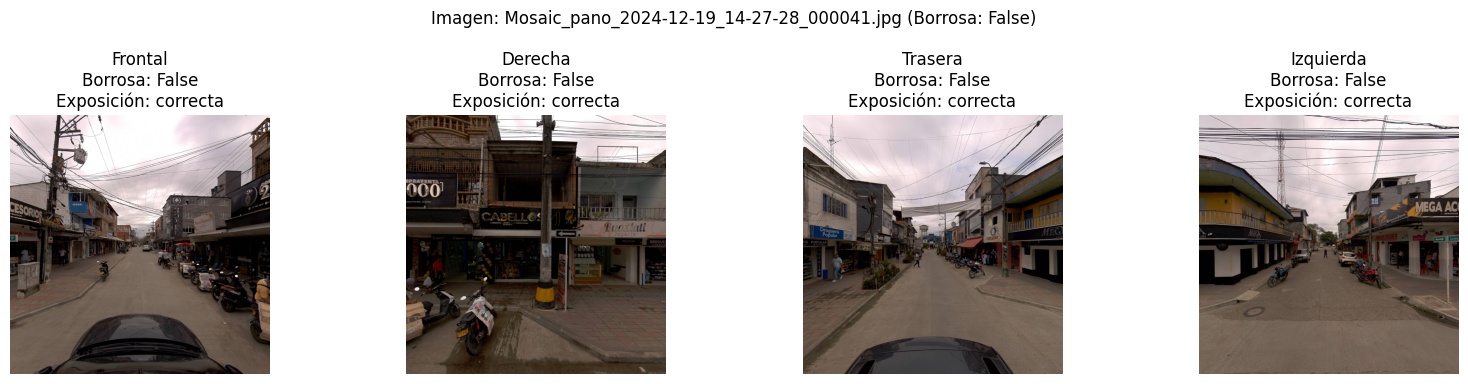

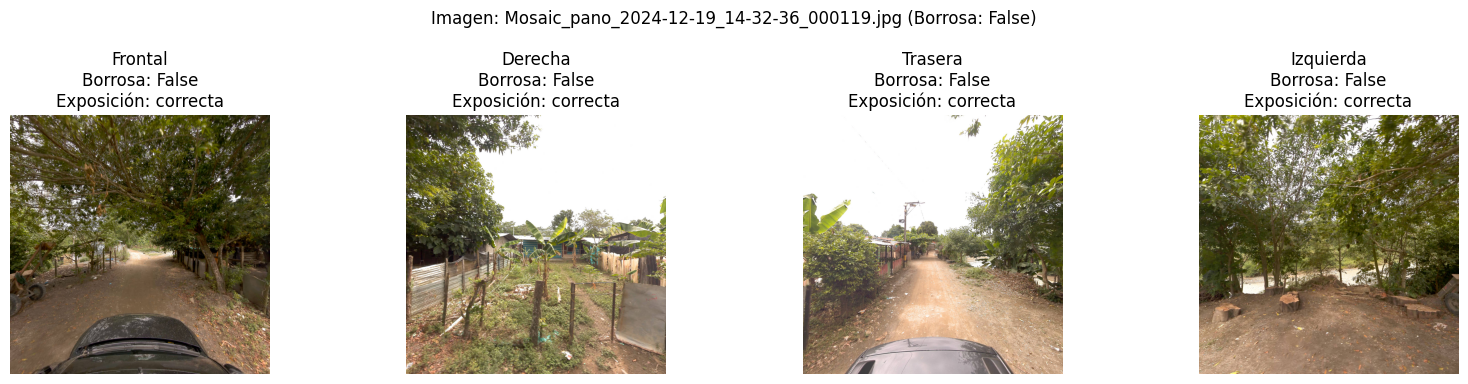

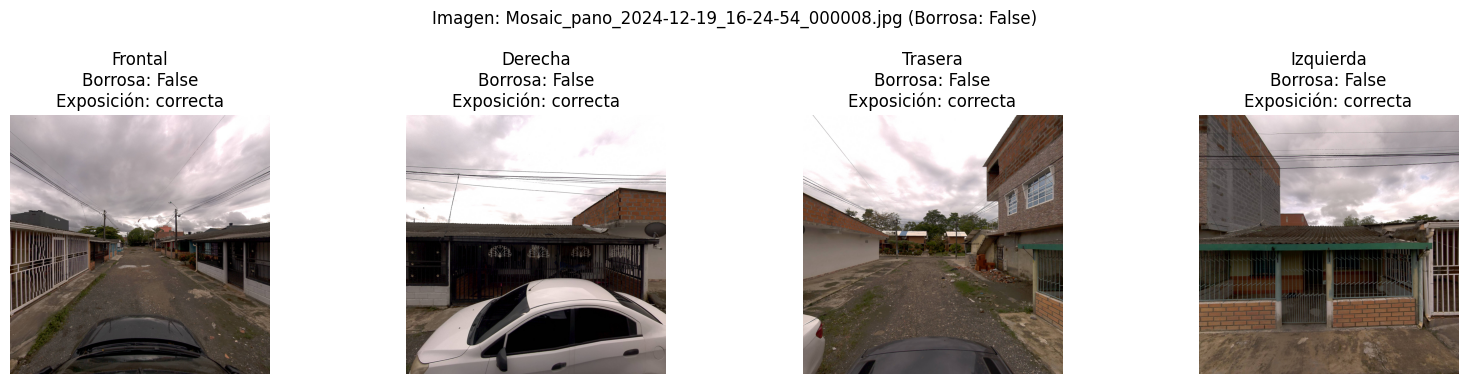


Imágenes con problemas de desenfoque:
Total imágenes desenfocadas: 0
No se detectaron imágenes borrosas.

Imágenes con problemas de exposición:
Total imágenes con exposición incorrecta: 2


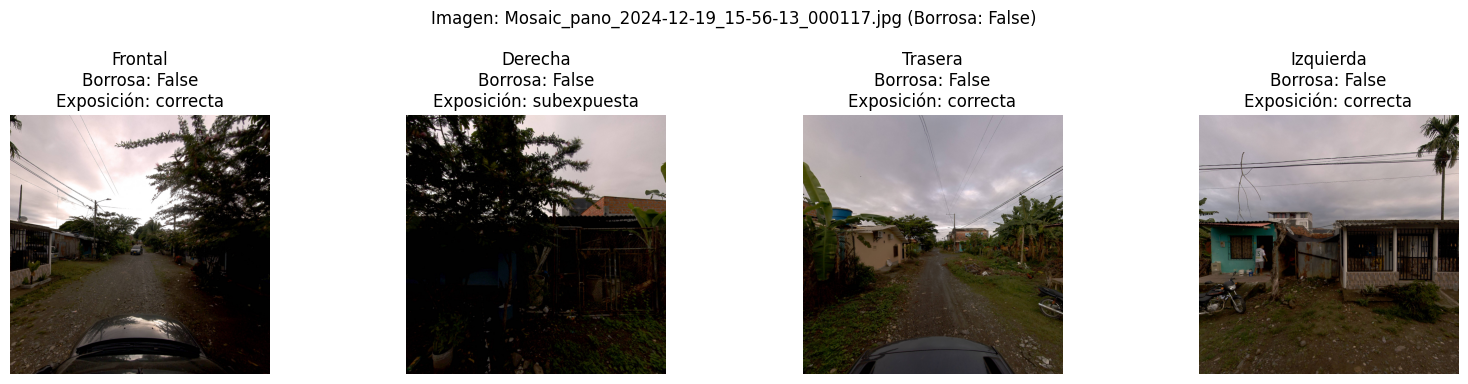

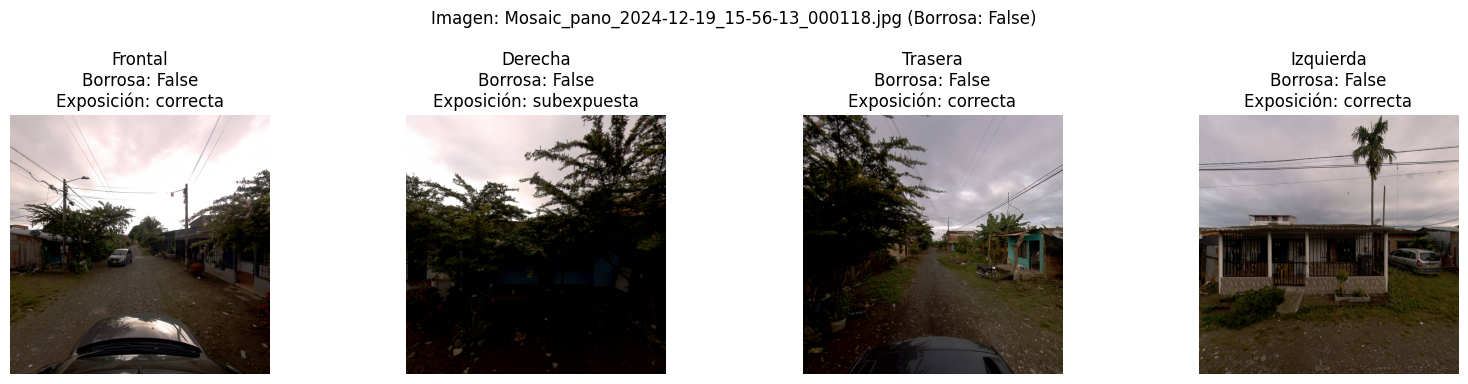

In [56]:
if __name__ == "__main__":
    # 0) Cargar resultados
    resultados_filtrados = pd.read_csv(csv_path)

    # 1) Muestra aleatoria del total procesado
    print("\nMuestra aleatoria de imágenes generales:")
    if not resultados_filtrados.empty:
        k = min(len(resultados_filtrados), 3)
        muestra_general = resultados_filtrados.sample(k)
        mostrar_varias_imagenes_desde_df(muestra_general)
        #mostrar_heatmaps(muestra_general)

    # 2) Imágenes con problemas de borrosidad
    print("\nImágenes con problemas de desenfoque:")
    df_borrosas = resultados_filtrados[resultados_filtrados['borrosa'] == True]
    print(f"Total imágenes desenfocadas: {len(df_borrosas)}")
    if not df_borrosas.empty:
        k = min(len(df_borrosas), 3)
        muestra_b = df_borrosas.sample(k)
        mostrar_varias_imagenes_desde_df(muestra_b)
        #mostrar_heatmaps(muestra_b)
    else:
        print("No se detectaron imágenes borrosas.")

    # 3) Imágenes con problemas de exposición
    print("\nImágenes con problemas de exposición:")
    df_expo = resultados_filtrados[resultados_filtrados['exposicion'] == True]
    print(f"Total imágenes con exposición incorrecta: {len(df_expo)}")
    if not df_expo.empty:
        k = min(len(df_expo), 3)
        muestra_e = df_expo.sample(k)
        mostrar_varias_imagenes_desde_df(muestra_e)
    else:
        print("No se detectaron imágenes con exposición incorrecta.")